# 4.4: 前馈式矩阵乘积态机器学习模型

> References:
> * [TensorNetwork for Machine Learning](https://arxiv.org/abs/1906.06329)
> * [Residual Matrix Product State for Machine Learning](https://arxiv.org/abs/2012.11841)
>    * ResMPS 很像 RNN

前馈式矩阵乘积态机器学习模型：
* 张量可作为从多个向量到单个向量（或张量）的映射
* 该映射可作为机器学习映射，其变分参数为张量元

步骤：
1. 特征映射 - 将各个特征映射为向量，将样本映射为多个向量的直积（与ADQC类似，见第3.4）
2. 计算特征向量与张量网络的收缩，获得输出向量

结构
![tn_machine](./images/tn_machine.png)

## 残差 MPS (ResMPS)

* 由于MPS长度等于样本特征个数（例如 MNIST 每个样本含784个特征），绝大部分矩阵乘积态会出现"**正交灾难**"（见4.1）
* ResMPS：利用"**残差(residual)**"的思想来避免正交灾难的发生

### 收缩算法

![res_mps_contraction](./images/res_mps_contraction.png)

* 从两端到中间（类别指标处）进行收缩，局域收缩表达式为：
  $$\sum_{\alpha_l s_l} v_{\alpha_l}^{(l)} \phi_{s_l}^{(l)} A_{\alpha_l s_l \alpha_{l+1}}^{(l)} = v_{\alpha_{l+1}}^{(l+1)}$$
* 向量$v^{(0)} = [1]$， $v^{(L-1)} = [1]$（注：最左侧张量的左虚拟指标维数为1，最右侧张量的右虚拟指标维数为1）
* ResMPS 的局域张量满足：$A_{:,0,:}^{(l)} = I$, $|A_{:,1,:}^{(l)}| \sim \varepsilon$
    * 中间指标的 0 分量是 $I$, 而 1 分量的模长是一个小量
* 选取特征映射：$x_l \rightarrow \phi^{(l)} = [1, x_l]$

> 残差项推导：
> 
> 1. ResMPS的局域张量满足: $A_{:,0,:}^{(l)} = I$, $|A_{:,1,:}^{(l)}| \sim \varepsilon$
> 2. 选取特征映射: $x_l \to \phi^{(l)} = [1, x_l]$
> 3. 代入上面的局域收缩表达式得到下面的式子
> 
> $$\boldsymbol{v}^{(l+1)} = \boldsymbol{v}^{(l)} + x_l\boldsymbol{v}^{(l)}A_{:,1,:}^{(l)}$$
> 
> 前半部分是特征和 0 分量（即 $I$ 相乘）得到，后半部分是 1 分量和上一步的 latent 相乘得到的残差项

> 证明：残差为微扰项时，可避免“正交灾难”
>
> 取模得: $|\boldsymbol{v}^{(l-1)}\boldsymbol{A}_{:,1,:}^{(l-1)}| \approx \varepsilon|\boldsymbol{v}^{(l-1)}|$
>
> 代入$\boldsymbol{v}^{(l)} = \boldsymbol{v}^{(l-1)} + x_{l-1}\boldsymbol{v}^{(l-1)}\boldsymbol{A}_{:,1,:}^{(l-1)}$ 并用三角不等式有:
>
> $|\boldsymbol{v}^{(l)}| \leq (1 + |x_{l-1}|\varepsilon)|\boldsymbol{v}^{(l-1)}| \leq (1 + |x_{l-1}|\varepsilon)(1 + |x_{l-2}|\varepsilon)|\boldsymbol{v}^{(l-2)}|$
>
> 仅保留到$\varepsilon$的线性项，有:
>
> $|\boldsymbol{v}^{(l)}| \lesssim [1 + (|x_{l-1}| + |x_{l-2}|)\varepsilon]|\boldsymbol{v}^{(l-2)}|$
>
> 依此类推:
>
> $|\boldsymbol{v}^{(l)}| \lesssim [1 + K\bar{x}\varepsilon]|\boldsymbol{v}^{(l-K)}|$
> 
> 类似地，可以证明 $[1 - K\bar{x}\varepsilon]|\boldsymbol{v}^{(l-K)}| \lesssim |\boldsymbol{v}^{(l)}| $
>
> 即 $\boldsymbol{v}^{(l)}$ 的模长仅近似地随收缩张量个数$K$线性变化，从而避免了指数地增大或缩小


* 实际计算中，可直接处理残差的计算，从而节省计算量
* 定义局域张量{$B^{(l)}$}，局域收缩为
    $$v_{a_{l+1}}^{(l+1)} = v_{a_l}^{(l)} + \sum_{a_l s_l} v_{a_l}^{(l)} \tilde{\phi}_{s_l}^{(l)} B_{a_l s_l a_{l+1}}^{(l)}$$

    $\tilde{\phi}^{(l)}$ 可看作是第 $l$ 个特征 $x_l$ 经过特征映射后所得的向量
* 考虑多个样本的并行处理，方法仍然是加入标记样本数目的指标，上式相应地变为
    $$v_{n a_{l+1}}^{(l+1)} = v_{n a_l}^{(l)} + \sum_{a_l s_l} v_{n a_l}^{(l)} \tilde{\phi}_{n s_l}^{(l)} B_{a_l s_l a_{l+1}}^{(l)}$$
    
    $\tilde{\phi}_{n,:}^{(l)}$ 为第 $n$ 个样本的 $l$ 个特征经过特征映射后所得的向量，指标 $n$ 的维数为样本个数

![res_mps_feature_mapping_comparison](./images/res_mps_feature_mapping_comparison.png)

### Code

In [1]:
# |default_exp networks.res_mps
# |export
import torch
from torch import nn
from einops import einsum, repeat

#### 残差项推导验证

In [2]:
a_l = 3
s_l = 5
a_l1 = 4

x = torch.randn(s_l)
v = torch.randn(a_l)
A = torch.randn(a_l, s_l, a_l1)

result = einsum(x, v, A, "s_l, a_l, a_l s_l a_l1 -> a_l1")

result1 = 0
for i in range(s_l):
    result1 = result1 + x[i] * (v.reshape(1, a_l) @ A[:, i, :])

result2 = torch.zeros(a_l1)

for i in range(a_l1):
    result2[i] = (A[:, :, i] @ x).inner(v)

assert torch.allclose(result, result1)
assert torch.allclose(result, result2)

#### Module

In [3]:
# |export
class ResMPSSimple(nn.Module):
    """
    A basic residual MPS model.
    """

    def __init__(
        self,
        *,
        num_features: int,
        feature_dim: int,
        num_classes: int,
        virtual_dim: int,
        eps_norm: float = 1e-4,
    ):
        super().__init__()
        assert num_features > 0, "num_features must be positive"
        assert num_classes > 0, "num_classes must be positive"
        assert feature_dim > 0, "feature_dim must be positive"
        assert virtual_dim > 0, "virtual_dim must be positive"
        self.num_features = num_features
        self.num_classes = num_classes
        self.virtual_dim = virtual_dim
        self.feature_dim = feature_dim
        self.class_idx = num_features // 2
        local_tensors = []
        dtype = torch.float32
        if num_features == 1:
            local_tensors.append(
                self._make_local_tensor(
                    virtual_dim,
                    feature_dim,
                    virtual_dim,
                    num_classes,
                    dtype=dtype,
                    eps_norm=eps_norm,
                )
            )
        else:
            for i in range(num_features):
                if i == self.class_idx:
                    tensor_shape = (virtual_dim, feature_dim, virtual_dim, num_classes)
                else:
                    tensor_shape = (virtual_dim, feature_dim, virtual_dim)
                local_tensors.append(
                    self._make_local_tensor(*tensor_shape, dtype=dtype, eps_norm=eps_norm)
                )
        self.local_tensors = nn.ParameterList(local_tensors)
        contract_vector = torch.ones(virtual_dim, dtype=dtype)
        contract_vector /= contract_vector.norm()
        self.contract_vector_left = nn.Parameter(contract_vector.clone(), requires_grad=False)
        self.contract_vector_right = nn.Parameter(contract_vector, requires_grad=False)

    @staticmethod
    def _make_local_tensor(*shape: int, dtype: torch.dtype, eps_norm: float) -> nn.Parameter:
        tensor = torch.randn(*shape, dtype=dtype)
        tensor /= tensor.norm()
        tensor = tensor * eps_norm
        return nn.Parameter(tensor, requires_grad=True)

    def forward(self, features: torch.Tensor) -> torch.Tensor:
        # features shape: (batch_size, num_features, feature_dim)
        batch_size, num_features, feature_dim = features.shape
        assert num_features == self.num_features, (
            f"num_features must be equal to {self.num_features}"
        )
        assert feature_dim == self.feature_dim, f"feature_dim must be equal to {self.feature_dim}"

        latent_left = repeat(
            self.contract_vector_left, "virtual_left -> batch virtual_left", batch=batch_size
        )
        for feature_idx in range(self.class_idx):
            latent = einsum(
                self.local_tensors[feature_idx],
                latent_left,
                features[:, feature_idx, :],
                "left feature right, batch left, batch feature -> batch right",
            )
            latent_left = latent + latent_left  # residual

        latent_right = repeat(
            self.contract_vector_right, "virtual_right -> batch virtual_right", batch=batch_size
        )
        for feature_idx in range(num_features - 1, self.class_idx, -1):
            latent = einsum(
                self.local_tensors[feature_idx],
                latent_right,
                features[:, feature_idx, :],
                "left feature right, batch right, batch feature -> batch left",
            )
            latent_right = latent + latent_right  # residual

        activation = einsum(
            self.local_tensors[self.class_idx],
            latent_left,
            latent_right,
            features[:, self.class_idx, :],
            "left feature right classes, batch left, batch right, batch feature -> batch classes",
        )
        return activation

#### Training

In [4]:
# |export feature_mapping
def linear_mapping(samples: torch.Tensor) -> torch.Tensor:
    """
    Apply linear feature mapping

    Args:
        samples: Input tensor of shape (batch_size, *)

    Returns:
        Output tensor of shape (batch_size, *, 2)
    """
    if samples.ndim == 1:
        samples = samples.reshape(1, -1)

    return torch.stack([samples, 1 - samples], dim=-1)

In [5]:
from tensor_network.utils.data import get_fashion_mnist_datasets
import os
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torchmetrics.classification import MulticlassAccuracy
from einops import rearrange
import matplotlib.pyplot as plt

cwd = os.getcwd()
cache_path = os.path.join(cwd, "datasets")

In [6]:
fmnist_trainset, fmnist_testset = get_fashion_mnist_datasets(cache_path)

In [7]:
# hyperparameters
device = torch.device("mps")
batch_size = 2000
lr = 1e-4
epochs = 30

feature_dim = 2
virtual_dim = 50

In [8]:
train_loader = DataLoader(fmnist_trainset, batch_size, True)
test_loader = DataLoader(fmnist_testset, batch_size, False)
num_classes = 10

In [9]:
model = ResMPSSimple(
    num_features=28 * 28,
    feature_dim=feature_dim,
    num_classes=num_classes,
    virtual_dim=virtual_dim,
    eps_norm=1e-4,
).to(device)
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)

In [10]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 3965100


In [11]:
losses = torch.empty(epochs)
train_accuracies = torch.empty(epochs)
progress_bar = tqdm(range(epochs))

for epoch in progress_bar:
    train_acc = MulticlassAccuracy(num_classes=num_classes).to(device)
    batch_loss = 0.0
    num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        data = data.to(device)
        data = rearrange(data, "b c h w -> b (c h w)")
        target = target.to(device)
        data = linear_mapping(data)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        num += batch_size
        batch_loss += loss.detach().cpu() * batch_size
        train_acc.update(output.detach(), target)
    losses[epoch] = batch_loss / num
    train_accuracies[epoch] = train_acc.compute()
    progress_bar.set_description(f"Epoch {epoch} loss: {losses[epoch]:.4f}")

  0%|          | 0/30 [00:00<?, ?it/s]

In [12]:
test_acc = MulticlassAccuracy(num_classes=num_classes).to(device)
with torch.no_grad():
    for data, target in tqdm(test_loader):
        batch_size = data.shape[0]
        data = data.to(device)
        data = rearrange(data, "b c h w -> b (c h w)")
        target = target.to(device)
        data = linear_mapping(data)
        output = model(data)
        test_acc.update(output, target)


test_acc = test_acc.compute()
print(f"Test accuracy: {test_acc}")

  0%|          | 0/5 [00:00<?, ?it/s]

Test accuracy: 0.8888000249862671


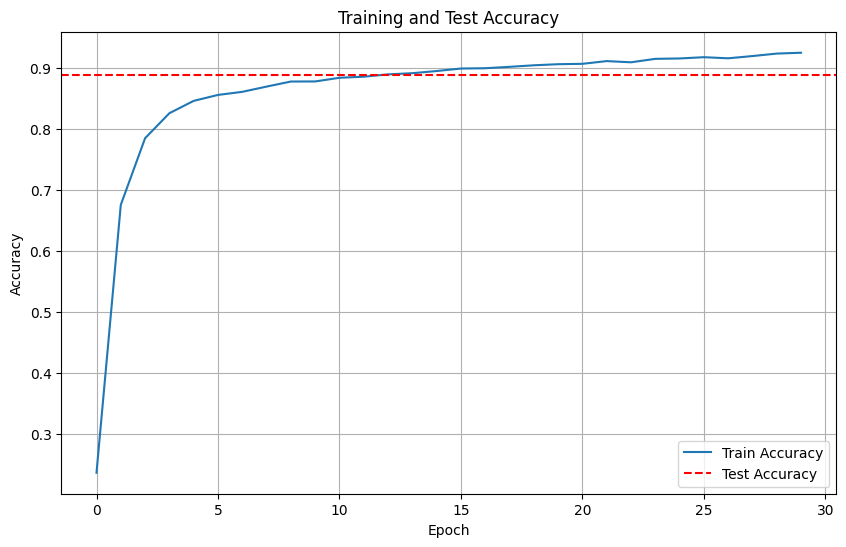

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_accuracies.cpu(), label="Train Accuracy")
plt.axhline(y=test_acc.cpu(), color="r", linestyle="--", label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy")
plt.legend()
plt.grid(True)

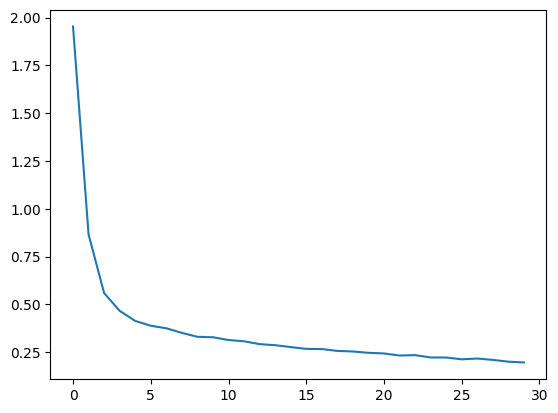

In [15]:
plt.plot(range(epochs), losses.cpu())